## Contruct gradients only within NPC mask

* get average NPC mask (L&R), 
* get a CM and take only rows of that mask, 
* generate covariance matrix
* fit GM to covariance matrix
* plot on brain surface (regions outside mask grey (nans))



#### Additional
* example loop over subs in 'loop_NPCmask-gradient_plots.py' executabel in terminal (tmux)
* mask fsavtofsav5


In [1]:
import numpy as np
import nibabel as nib
from nilearn import datasets
import os.path as op
import os
from brainspace.gradient import GradientMaps
from utils import get_basic_mask
from  nilearn.datasets import fetch_surf_fsaverage
import nilearn.plotting as nplt
import matplotlib.pyplot as plt

bids_folder = '/mnt_03/ds-dnumrisk' 
plot_folder = op.join(bids_folder, 'plots_and_ims/gradient_stuff')

from os import listdir
subList = [f[4:6] for f in listdir(op.join(bids_folder)) if f[0:4] == 'sub-' and len(f)==6]

fsaverage = fetch_surf_fsaverage('fsaverage5') 



In [2]:
# get masks
surf_mask_L = op.join(bids_folder, 'derivatives/surface_masks', 'desc-NPC_L_space-fsaverage5_hemi-lh.label.gii')
surf_mask_L = nib.load(surf_mask_L).agg_data()
surf_mask_R = op.join(bids_folder, 'derivatives/surface_masks', 'desc-NPC_R_space-fsaverage5_hemi-rh.label.gii')
surf_mask_R = nib.load(surf_mask_R).agg_data()
nprf_r2 = np.concatenate((surf_mask_L, surf_mask_R))

mask, labeling_noParcel = get_basic_mask()
nprf_r2_mask = nprf_r2[mask]
np.shape(nprf_r2)


(20484,)

In [3]:
sub = 'All'
cm_file = op.join(bids_folder, 'derivatives', 'correlation_matrices', 'cm_av_group-All.npy' ) #f'sub-{sub}_unfiltered.npy')
cm = np.load(cm_file)

In [ ]:
cm_NPC = cm[np.bool_(nprf_r2_mask),:]
cm_NPC_cov = cm_NPC.dot(cm_NPC.T) # covariance matrix
np.shape(cm_NPC_cov)

cm_NPC = cm_NPC_cov

In [9]:
cm_NPC = cm[np.bool_(nprf_r2_mask),:][:,np.bool_(nprf_r2_mask)]
np.shape(cm_NPC)


(1510, 1510)

In [10]:

print(f'start fitting gradintes now')
gm = GradientMaps(n_components=3) # defaults: approacch = 'dm', kernel = None
gm.fit(cm_NPC)
print(f'finished sub-{sub}: gradients generated')
  

start fitting gradintes now


/home/ubuntu/miniconda3/envs/numrefields/lib/python3.10/site-packages/brainspace-0.1.4-py3.10.egg/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


finished sub-All: gradients generated


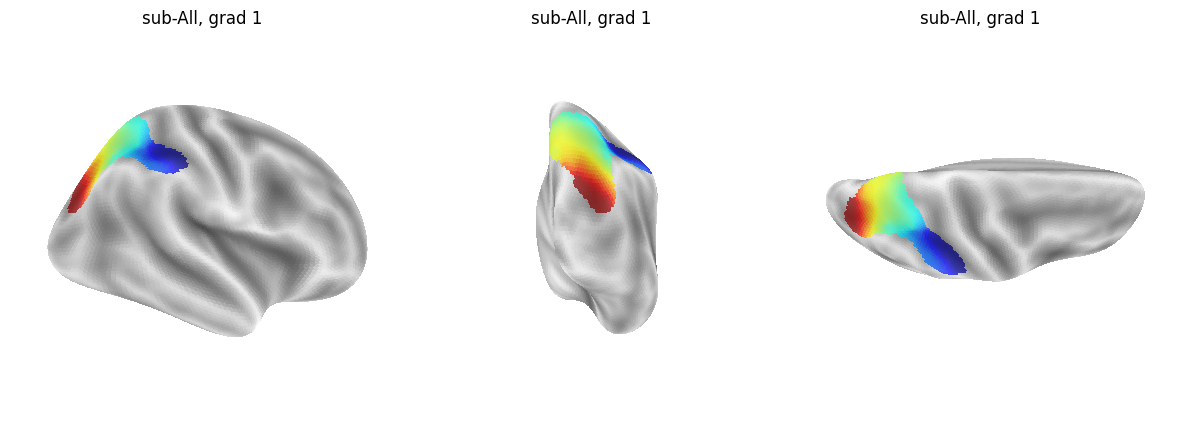

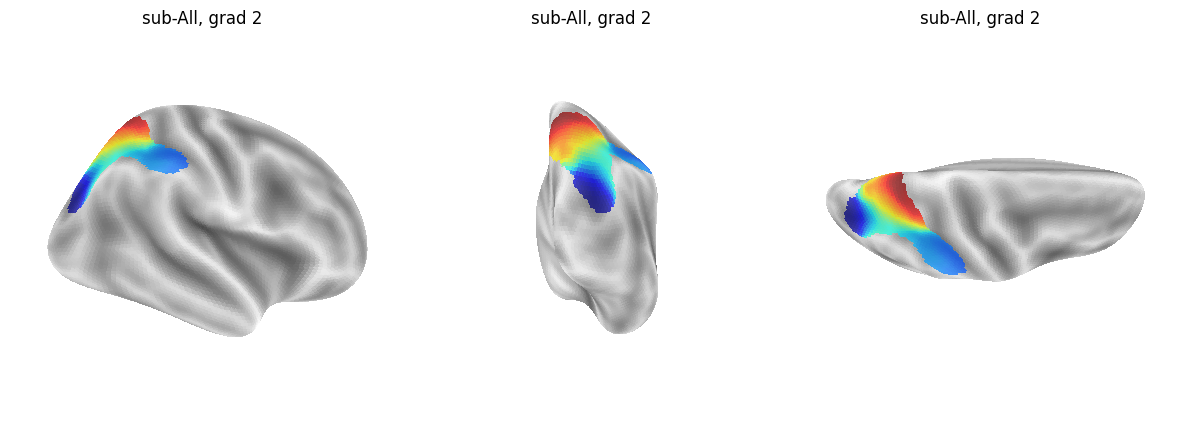

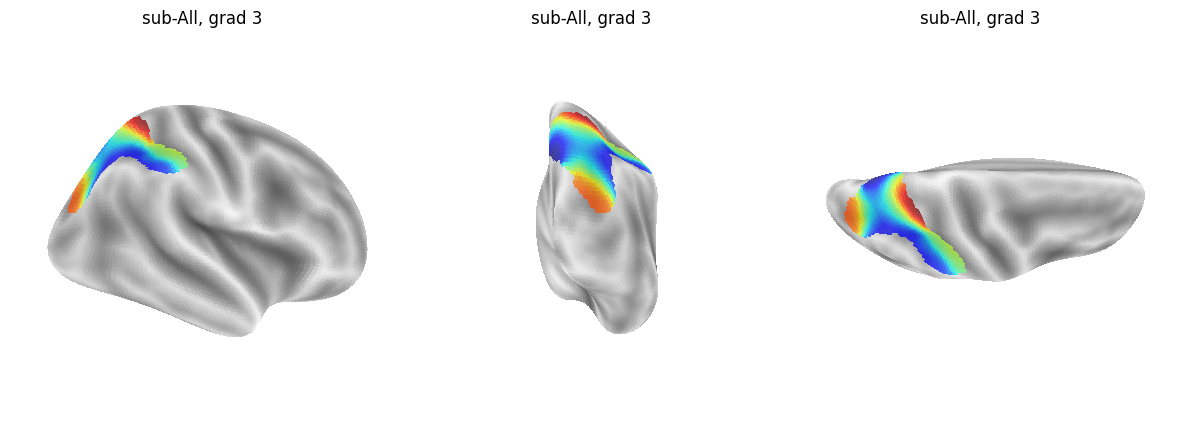

In [11]:
views = ['medial','posterior','dorsal']

for n_grad in range(3):
    map = np.full(np.shape(mask), np.nan)#  np.zeros(np.shape(mask)) # 
    map[np.bool_(nprf_r2)] = gm.gradients_.T[n_grad,:]
    gms = np.split(map,2) # for i, hemi in enumerate(['L', 'R']): --> left first
    gm_r = gms[1]# right    
    
    figure, axes = plt.subplots(nrows=1, ncols=len(views),figsize = (15,8), subplot_kw=dict(projection='3d'))
    for i,view in enumerate(views):
        nplt.plot_surf(surf_mesh= fsaverage.infl_right, surf_map= gm_r, # infl_right # pial_right
                view= view,cmap='jet', colorbar=False, title=f'sub-{sub}, grad {n_grad+1}',
                bg_map=fsaverage.sulc_right, bg_on_data=True,darkness=0.7, axes=axes[i]) 
    figure.subplots_adjust(wspace=0.01)



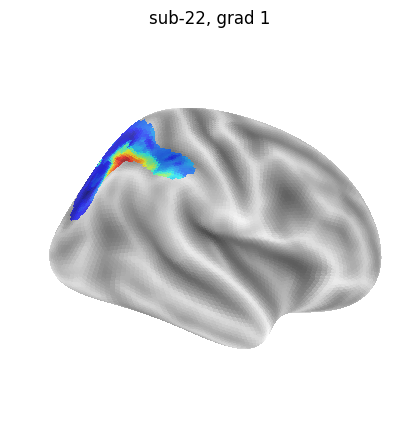

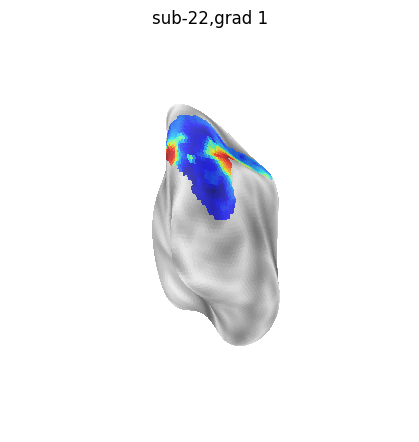

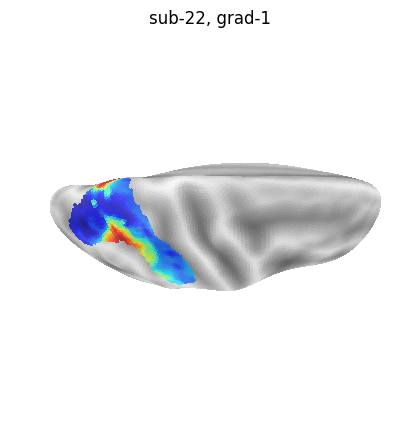

In [ ]:



gms = np.split(map,2) # for i, hemi in enumerate(['L', 'R']): --> left first
gm_r = gms[1]# right
nplt.plot_surf(surf_nmesh= fsaverage.infl_right, surf_map= gm_r, # infl_right # pial_right
            view= 'medial',cmap='jet', colorbar=False, title=f'sub-{sub}, grad {n_grad+1}',
            bg_map=fsaverage.sulc_right, bg_on_data=True,darkness=0.7) 
plt.show()
nplt.plot_surf(surf_mesh= fsaverage.infl_right, surf_map= gm_r, # infl_right # pial_right
            view= 'posterior',cmap='jet', colorbar=False, title=f'sub-{sub},grad {n_grad+1}',
            bg_map=fsaverage.sulc_right, bg_on_data=True,darkness=0.7) 
plt.show()
nplt.plot_surf(surf_mesh= fsaverage.infl_right, surf_map= gm_r, # infl_right # pial_right
            view= 'dorsal',cmap='jet', colorbar=False, title=f'sub-{sub}, grad-{n_grad+1}',
            bg_map=fsaverage.sulc_right, bg_on_data=True,darkness=0.7) 
plt.show()

## Addtional

finished sub-01: gradients generated


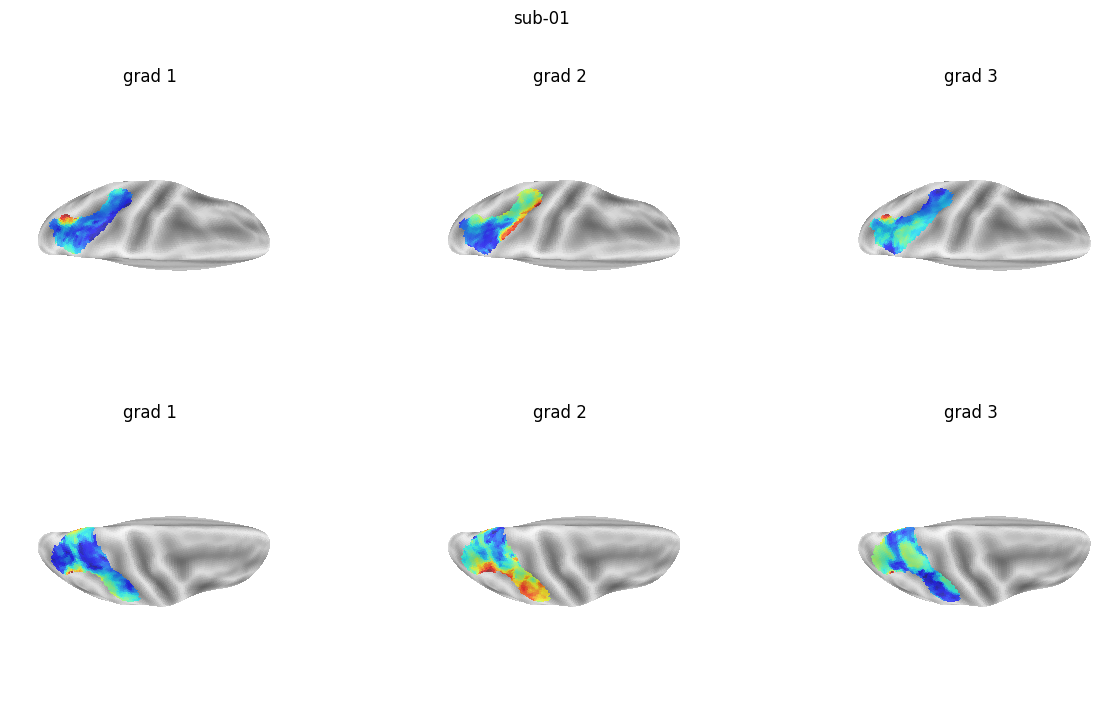

In [ ]:
# example, loop over subs in 'loop_NPCmask-gradient_plots.py' executabel in terminal (tmux)

sub= '01'
cm_file = op.join(bids_folder, 'derivatives', 'correlation_matrices', f'sub-{sub}_unfiltered.npy')
cm = np.load(cm_file)
cm_NPC = cm[np.bool_(nprf_r2_mask),:]
cm_NPC_cov = cm_NPC.dot(cm_NPC.T) # covariance matrix

gm = GradientMaps(n_components=3) # defaults: approacch = 'dm', kernel = None
gm.fit(cm_NPC_cov)
print(f'finished sub-{sub}: gradients generated')

figure, axes = plt.subplots(nrows=2, ncols=3,figsize = (15,8), subplot_kw=dict(projection='3d'))
for n_grad in range(3):
    map = np.full(np.shape(mask), np.nan) #  np.zeros(np.shape(mask)) # 
    map[np.bool_(nprf_r2)] = gm.gradients_.T[n_grad,:]
    gms = np.split(map,2) 
    
    for n_hemi, hemi in enumerate(['L','R']):
        gm_ = gms[n_hemi]# right    
        surf_mesh = fsaverage.infl_left if hemi == 'L' else fsaverage.infl_right
        bg_map = fsaverage.sulc_left  if hemi == 'L' else fsaverage.sulc_right

        nplt.plot_surf(surf_mesh= surf_mesh, surf_map= gm_, 
                view= view,cmap='jet', colorbar=False, title=f'grad {n_grad+1}',
                bg_map=bg_map, bg_on_data=True,darkness=0.7, axes=axes[n_hemi, n_grad]) 
            
figure.suptitle(f'sub-{sub}')
plt.savefig(op.join(plot_folder, f'sub-{sub}_NPCmask-gradient.png'),bbox_inches='tight', dpi=300)

In [3]:
from nipype.interfaces.freesurfer import SurfaceTransform # needs the fsaverage & fsaverage5 in ..derivatives/freesurfer folder!
source_space = 'fsaverage'
target_space = 'fsaverage5'

for hemi in ['L', 'R']:
    fs_hemi= 'lh' if hemi == 'L' else 'rh'
    in_file = op.join(bids_folder, 'derivatives/surface_masks', f'desc-NPC_{hemi}_space-{source_space}_hemi-{fs_hemi}.label.gii')
    sxfm = SurfaceTransform(subjects_dir=op.join(bids_folder,'derivatives','freesurfer'))
    sxfm.inputs.source_file = in_file
    sxfm.inputs.out_file =  in_file.replace(source_space, target_space)
    sxfm.inputs.source_subject = source_space 
    sxfm.inputs.target_subject = target_space 
    sxfm.inputs.hemi = fs_hemi

    r = sxfm.run()

241126-12:58:32,439 nipype.interface INFO:
	 stderr 2024-11-26T12:58:32.439395:** DA[0] has coordsys with intent NIFTI_INTENT_NONE (should be NIFTI_INTENT_POINTSET)
241126-12:58:33,115 nipype.interface INFO:
	 stdout 2024-11-26T12:58:33.115000:
241126-12:58:33,115 nipype.interface INFO:
	 stdout 2024-11-26T12:58:33.115000:7.3.2
241126-12:58:33,116 nipype.interface INFO:
	 stdout 2024-11-26T12:58:33.115000:
241126-12:58:33,116 nipype.interface INFO:
	 stdout 2024-11-26T12:58:33.115000:setenv SUBJECTS_DIR /mnt_03/ds-dnumrisk/derivatives/freesurfer
241126-12:58:33,117 nipype.interface INFO:
	 stdout 2024-11-26T12:58:33.115000:cd /home/ubuntu/git/numrisk/numrisk/fmri_analysis/gradients
241126-12:58:33,117 nipype.interface INFO:
	 stdout 2024-11-26T12:58:33.115000:mri_surf2surf --hemi lh --tval /mnt_03/ds-dnumrisk/derivatives/surface_masks/desc-NPC_L_space-fsaverage5_hemi-lh.label.gii --sval /mnt_03/ds-dnumrisk/derivatives/surface_masks/desc-NPC_L_space-fsaverage_hemi-lh.label.gii --srcsubj

In [ ]:
import seaborn as sns
sns.heatmap(cm_NPC_cov)